# Tarefa 02: Regressão Logística e Regularização

## Introdução

<b>Disciplina: </b> Tópicos especiais de Física.

<b>Professor: </b> Saulo D. S. Reis (Departamento de Física -- UFC).

Neste exercício, você irá implementar uma regressão logística sem regularização, além de sua versão com regularização.

Toda a informação que você precisa para resolver essa tarefa está contida neste notebook, e todo o código que você irá implementar será escrito também neste notebook.

Estas tarefas foram adaptadas das tarefas originais presentes no excelente curso introdutório de Machine Learning do Prof. Andrew Ng, presente no Coursera que podem ser encontrados nesse [link](https://www.coursera.org/learn/machine-learning).

In [1]:
#!pip install matplotlib
#!pip install scipy

In [2]:
# Usado para manipular os diretórios do sistema operacioal
import os

# Usada para operações numéricas e com vetores em python
import numpy as np

# Usada para plots
from matplotlib import pyplot

# Módulo de otimização do scipy
from scipy import optimize

# Biblioteca escrita para esta tarefa com funções adicionais
import utils

# plote as figuras dentro deste jupyter notebook
%matplotlib inline

## Avaliação


Após completar essa tarefa, se certifique de submetê-la pelo sigga dentro do prazo.

A distribuição de pontos será feita de acordo com a tabela abaixo:

**Tarefas**



| Seção | Parte                                           |Função                     | Pontos 
| :-      |:-                                    | :-                    | :-:
| 1       | [Função sigmóide](#section1)                   | [`sigmoid`](#sigmoid) | 5      
| 2       | [Função custo da regressão logística](#section2) | [`costFunction`](#costFunction) | 30     
| 3       | [Gradiente para a regressão logística](#section2)     | [`costFunction`](#costFunction) | 30     
| 4       | [Função para previsão](#section4)                     | [`predict`](#predict) | 5      
| 5       | [Função custo regularizada da RL](#section5)      | [`costFunctionReg`](#costFunctionReg) | 15     
| 6       | [Gradiente regularizado da RL](#section5)          | [`costFunctionReg`](#costFunctionReg) | 15     
|     $~$ | Total de pontos                         |$~$  | 100    

## 1 Regressão logística

Nesta parte da tarefa, você irá construir um modelo de regressão logística para prever se um estudante é ou não aprovado no processo seletivo de um curso de pós-graduação. Suponha que você queira determinar a chance de cada estudante baseado no resultado do mesmo em dois exames. Você possui o dado histórico de estudantes de processos seletivos anteriores que você pode utilizar como conjunto de treino para sua regressão logística. Para cada amostra de treino você possui o resultado de cada estudante nos dois exames e o resultado de sua seleção. 

Sua tarefa é construir um modelo de classificação que estime a probabilidade do estudante ser selecionado para o programa de pós-graduação baseado nos seus resultados em dois exames.

A próxima célula irá carregar o conjunto de dados e seus rótulos correspondentes:

In [3]:
# Carrega os dados
# As primeiras duas colunas contém o resultados dos exames e a terceira coluna
# contém o resultado da seleção.
data = np.loadtxt(os.path.join('Data', 'tar2data1.txt'), delimiter=',')
X, y = data[:, 0:2], data[:, 2]

### 1.1 Visualizando os dados

Antes de implementar qualquer algoritmo de aprendizado, é importante visualizar o conjunto de dados se possível. Mostraremos os dados em uma figura bidimensional evocando a função `plotData`. Você irá completar o código de `plotData` de modo que os eixos sejam o resultado dos dois exames, e o resultado da seleção seja apresentado com símbolos diferentes.

Para ajudar na sua familiarização com a manipulação de dados e suas visualizações, a função `plotData` está apenas parcialmente implementada de modo que você deva tentar completá-la. Como esta parte da tarefa não é obrigatória, as linhas de código que completam o código estão fornecidas abaixo. Se você escolher copiar o exemplo, certifique-se de entender todos os comandos e operações consultando a documentação do `matplotlib` e do `numpy`.

```python
# Encontrando os índices dos rótulos positivos e negativos
pos = y == 1
neg = y == 0

# Visualizando o dado
pyplot.plot(X[pos, 0], X[pos, 1], 'kD', mfc='lightblue', ms=8, mec='b')
pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='pink', ms=8, mec='r', mew=1)
```

In [4]:
def plotData(X, y):
    """
    Imprime o conjunto de dados X e y em uma figura. Imprime as 
    amostras positivas com diamantes azuis e as negativas com círculos vermelhos.
    
    Parâmetros
    ----------
    X : tipo_array
        Uma matriz mx2 representando o conjunto de dados. 
    
    y : tipo_array
        Rótulos do conjunto de dados. Um verto de tamanho (m, ).
    
    Instruções
    ----------
    Imprima as amostras positivas e negativas em uma figura 2D usando 
    a opção 'kD' para amostras positivas e 'ko' para exemplos positivos.
    """
    # Criando a figura
    fig = pyplot.figure()
    
    # Encontrando os índices dos rótulos positivos e negativos
    pos = y == 1
    neg = y == 0

# Visualizando o dado
    pyplot.plot(X[pos, 0], X[pos, 1], 'kD', mfc='lightblue', ms=8, mec='b')
    pyplot.plot(X[neg, 0], X[neg, 1], 'ko', mfc='pink', ms=8, mec='r', mew=1)
    
    return fig

Agora, chamamos a função para visualizar o dado carregado

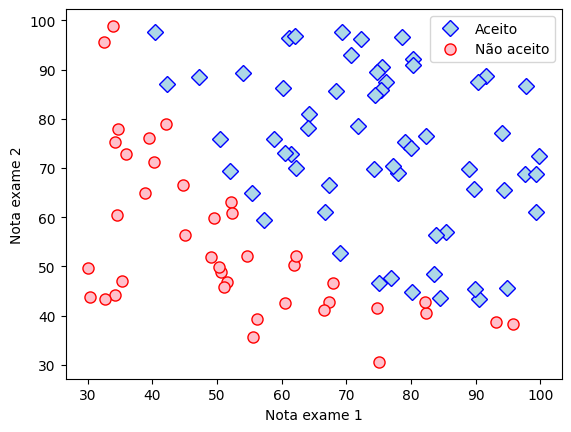

In [5]:
plotData(X, y)
# add axes labels
pyplot.xlabel('Nota exame 1')
pyplot.ylabel('Nota exame 2')
pyplot.legend(['Aceito', 'Não aceito'])
pass

<a id="section1"></a>
### 1.2 Implementação

#### 1.2.1 Exercício de aquecimento: função sigmóide

Antes de começarmos de fato com a função custo, lembre-se de que na regressão logística, a hipótese é definida como:

$$ h\left(\Theta,x\right) = g\left(\Theta^T x\right),$$

onde $g$ é a função sigmóide dada por:

$$g(z) = \frac{1}{1+e^{-z}}.$$

Seu primeiro passo é a implementação da função `sigmoid` para que você possa chamá-la no resto de seu código. Quando terminada a implementação, teste-a em alguns valores de `sigmoid(x)` em uma nova célula. Para valores grandes de $x$, a função deve retornar valores próximos de 1, enquanto que para valores negativos grandes, a sigmóide deve retornar valores próximos de 0. Para $x=0$, a função sigmóide deve ser exatamente igual à 0,5. Seu código deve funcionar tanto para vetores quanto para matrizes. **Quando aplicada em uma matriz, a função deve retornar uma matriz de mesma dimensão, onde cada elemento é o valor da sigmóide do respectivo elemento da matriz original.**
<a id="sigmoid"></a>

In [6]:
def sigmoid(z):
    """
    Calcula a função sigmóide de uma dada entrada z.
    
    Parâmetros
    ----------
    z : tipo_array
        Entrada da função sigmóide. Este pode ser um número, um vetor ou mesmo 
        uma matriz bidimensional.
    
    Saída
    -----
    g : tipo_array
        valor calculado da função sigmóide. g possui a mesma forma de z, uma vez
        que a sigmóide é calculada elemento por elemento.
        
    Instruções
    ----------
    Calcule o valor da função sigmóide para a entrada z (z pode ser uma matriz, um
    vetor ou mesmo um escalar).
    """
    # converta a entrada em um tipo array do numpy
    z = np.array(z)
     
    g = np.zeros(z.shape)

    return 1/(1+np.exp((-1)*z))

A próxima célula calcula o valor da sigmóide em `z=0`. Você deve receber o valor de 0.5 como saída. Tente valores diferentes de `z` e verifique sua implementação.

In [8]:
# Teste da implementação da função sigmóide
z = 0
g = sigmoid(z)

print('g(', z, ') = ', g)

g( 0 ) =  0.5


<a id="section2"></a>
#### 1.2.2 Função custo e seu gradiente

Agora você implementará a função custo e seu gradiente para uma regressão logística. Antes de seguir para a função custo, adicionamos o termo de interceptação à X.

In [10]:
# Configura a matriz X apropriadamente e adicione os termos de interceptação

# Aqui m é o número de amostras de treino e n o número de features de cada amostra
m, n = X.shape

# Adicione o termo de interceptação
X = np.concatenate([np.ones((m, 1)), X], axis=1)

Agora, complete o código da função `costFunction` e retorne seu valor além do gradiente da mesma. Lembre-se que a função custo na regressão logística é dada por

$$ J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h\left(\Theta,x^{(i)}\right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h\left(\Theta,x^{(i)} \right) \right) \right],$$

e que seu gradiente é um vetor com a mesma dimensão do vetor $\Theta$, onde o $j$-ésimo elemento (para $j = 0, 1, \cdots , n$) é dado pela seguinte expressão:

$$ \frac{\partial J\left(\Theta\right)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h\left(\Theta , x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} .$$

Note que por mais que a expressão para o gradiente pareça idêntico ao da regressão linear, ela é diferente, visto que as regressões linear e logística possuem definições diferentes de $h\left(\Theta,x\right)$.
<a id="costFunction"></a>

In [15]:
def costFunction(theta, X, y):
    """
    Calcule o custo o gradiente para a regressão logística.
    
    Parâmetros
    ----------
    theta : tipo_array
        Parâmetros para a regressão logística. Um vetor na forma (n+1, ).
        of shape (n+1, ).
    
    X : tipo_array
        Conjunto de treino na forma (m X n+1) onde m é o número de
        amostras de treino e n o número de features. Assumimos que 
        os termos de interceptação já foram adicionados.
    
    y : tipo_array
        Rótulos de entrada. Um vetor na forma (m, ).
    
    Returns
    -------
    J : float
        Valor calculado da função custo. 
    
    grad : tipo_array
        Um vetor de forma (n+1, ) contendo o gradiente do custo com
        respeito à theta.
        
    Instruções
    ----------
    Calcule o custo associado a um theta particular. Você deve atribuir à
    J o valor do custo. Calcule as derivadas parciais do custo com respeito
    a cada theta_j e atribua seus valores à quantidade grad.
    """
    # Inicializa quantidades úteis
    m = y.size  # Número de amostras de treino

    grad = np.zeros(theta.shape)

    g = sigmoid(np.dot(X,theta)) # Função sigmoide
    J = np.sum(np.dot((-1)*y,np.log(g)) - np.dot((1-y),np.log(1-g)))/m # Função custo
    grad = np.dot(g-y,X)/m # Gradiente # Soma implícita

    return J, grad

Uma vez que você tenha terminado a sua implementação da `costFunction`, teste sua implementação com dois conjuntos diferentes de $\Theta$ na próxima célula.

In [16]:
# Inicializa os parâmetros de ajuste
initial_theta = np.zeros(n+1)

cost, grad = costFunction(initial_theta, X, y)

print('Custo para iniciais de theta (zeros): {:.6f}'.format(cost))
print('Valor experado para a função custo (aprox): 0.693\n')

print('Gradiente para iniciais de theta (zeros):')
print('\t[{:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Valor experado para os gradientes (aprox):\n\t[-0.1000, -12.0092, -11.2628]\n')

# Calcula e verifica os valores do custo e do gradiente
# para valores não-nulos de theta
test_theta = np.array([-24, 0.2, 0.2])
cost, grad = costFunction(test_theta, X, y)

print('Custo para theta de teste: {:.6f}'.format(cost))
print('Valor experado para a função custo (aprox): 0.218\n')

print('Gradiente para theta de teste:')
print('\t[{:.6f}, {:.6f}, {:.6f}]'.format(*grad))
print('Valor experado para os gradientes (aprox):\n\t[0.043, 2.566, 2.647]')

Custo para iniciais de theta (zeros): 0.693147
Valor experado para a função custo (aprox): 0.693

Gradiente para iniciais de theta (zeros):
	[-0.100000, -12.009217, -11.262842]
Valor experado para os gradientes (aprox):
	[-0.1000, -12.0092, -11.2628]

Custo para theta de teste: 0.218330
Valor experado para a função custo (aprox): 0.218

Gradiente para theta de teste:
	[0.042903, 2.566234, 2.646797]
Valor experado para os gradientes (aprox):
	[0.043, 2.566, 2.647]


#### 1.2.3 Aprendendo os parâmetros $\Theta$ utilizando `scipy.optimize`

Nas tarefas anteriores, você encontrou os valores ótimos dos parâmentros de uma regressão linear ao implementar um gradiente descendente. Você implementou a função custo e seu gradiente, depois executou passos de um gradiente descendente. Agora, ao invés de adotar esse procedimento, você irá usar o [módulo `scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html). SciPy é uma biblioteca do `python` para cálculos numéricos. Ela oferece um módulo de otimização para encontrar raízes e mínimos de funções. Para o caso do `scipy 1.0`, a função `scipy.optimize.minimize` é o método a ser utilizado em problemas de otimização (com ou sem vínculos).

Para a regressão logística, queremos otimizar a função custo $J\left(\Theta\right)$ com os parâmetros $\Theta$. De forma prática, você usará `optimize.minimize` para encontrar os melhores parâmentros $\Theta$ para a função custo da regressão logística dado um conjunto de parâmetros fixo (valores de X e y). Você passará à função `optimize.minimize` os seguintes argumentos de entrada:
- `costFunction`: Uma função custo que, dado um conjunto de treino e um $\Theta$ particular, calcula a função custo e seu gradiente para uma regressão logística com respeito à $\Theta$ para o cinjunto de dados (X, y). É importante notar que passamos apenas o nome da função sem parênteses. Isso significa que estamos passando apenas uma referência dessa função, e não calculando o valor resultante dessa função.
- `initial_theta`: O conjunto inicial de $\Theta$ que pretendemos otimizar.
- `(X, y)`: Estes são os argumentos adicionais da função `costFunction`.
- `jac`: Indica que a função custo fornecida já retorna o Jacobiano (gradiente) junto com o valor do custo. (True)
- `method`: Método de otimização utilizado. (TNC -- método de Newton truncado)
- `options`: Opções adicionais que podem ser específicas de um método de otimização. No que segue, apenas dizemos ao algoritmo que execute um máximo número de iterações antes de terminar.

Se você completou a função `costFunction` corretamente, `optimize.minimize` convergirá aos parâmentros corretos e retornará os valores finais do custo e $\Theta$ como um objeto de uma classe. Note que ao usarmos `optimize.minimize`, você não terá que escrever nenhum loop, ou mesmo determinar uma taxa de aprendizado. Tudo isso é feito pela função `optimize.minimize`: Você apenas precisa fornecer uma função que calcule o custo e seu gradiente.

No que segue, já implementamos o código para executar `optimize.minimize` com os argumentos corretos.

In [17]:
# Configura o argumento options para a função optimize.minimize
options= {'maxiter': 400}

# Consulte a documentação de optimize.minimize do scipy para a descrição sobre
# o uso de diferentes parâmetros.
# A função retorna um objeto `OptimizeResult`.
# Aqui utilizamos o algoritmo de Newton truncado para o procedimento de otimização
res = optimize.minimize(costFunction,
                        initial_theta,
                        (X, y),
                        jac=True,
                        method='TNC',
                        options=options)

# A propriedade fun do objeto `OptimizeResult` retorna 
# o valor de costFunction para os valores de theta otimizados
cost = res.fun

# Os valores otimizados de theta estão na propriedade x
theta = res.x

# Imprima theta na tela
print('Custo encontrado por optimize.minimize: {:.6f}'.format(cost))
print('Custo esperado (aprox): 0.203\n');

print('theta:')
print('\t[{:.6f}, {:.6f}, {:.6f}]'.format(*theta))
print('Theta esperado (aprox):\n\t[-25.161, 0.206, 0.201]')

Custo encontrado por optimize.minimize: 0.203498
Custo esperado (aprox): 0.203

theta:
	[-25.161319, 0.206232, 0.201471]
Theta esperado (aprox):
	[-25.161, 0.206, 0.201]


C:\Users\danie\AppData\Local\Temp\ipykernel_7944\1370012265.py:8: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = optimize.minimize(costFunction,


Um vez `optimize.minimize` tenha finalizado sua execução, usaremos os valores finais de $\Theta$ para visualizar a linha divisória de decisão sobre o conjunto de treino, como o apresentado na figura abaixo. 

![](Figures/decision_boundary1.png)

Para fazê-lo, já escrevemos a função `plotDecisionBoundary` para visualizar a linha divisória de decisão sobre o conjunto de treino. Não é necessário escrever nenhum código para visualizar a linha divisória, mas recomendamos fortemente que você estude o código da `plotDecisionBoundary` para ver como tais contornos usam os valores de $ \Theta$. Você pode encontrar essa função no arquivo `utils.py` que acompanha essa tarefa.

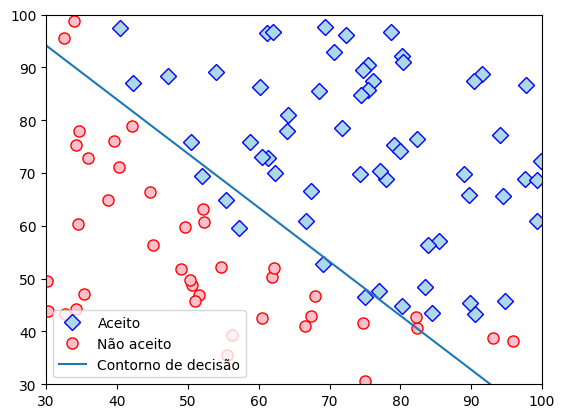

In [18]:
# Imprime o contorno
utils.plotDecisionBoundary(plotData, theta, X, y)

<a id="section4"></a>
#### 1.2.4 Executando a regressão logística

Após aprender os parâmetros, você pode utilizar o modelo para prever se um candidato em particular será adimitido. Esse candidato possui nota 45 para o Exame 1 e 85 para o Exame 2. Você deve verificar uma probabilidade de admissão de 0.776. Outra forma de averiguar a qualidade dos parâmetros $\Theta$ aprendidos é verificar a performance do nosso modelo no conjunto de treino. Neste parte da tarefa, sua tarefa é completar a função `predict`. A função `predict` retorna previsões "1" e "0" dado um conjunto de dados e um vetor $\Theta$.
<a id="predict"></a>

In [19]:
def predict(theta, X):
    """
    Preveja se o rótulo é 0 ou 1 utilizando o modelo aprendido pelo
    ajuste logístico. Calcula as previsões para X utilizando o limiar
    de 0.5, ou seja, se a sigmoid(theta.T*X) >= 0.5, preveja 1).
    
    Parameters
    ----------
    theta : tipo_array
        Parâmetros da regressão logística. Um vetor na forma (n+1, ).
    
    X : tipo_array
        Dados utilizados para fazer as previsões. As linhas são as amostras
        sobre as quais as previsões serão feitas e as colunas os features.

    Returns
    -------
    p : tipo_array
        Predictions and 0 or 1 for each row in X. 
    
    Instruções
    ----------
    Complete o seguinte código para fazer previsões usando os parâmetros
    aprendidos pela regressão logística. Você deve atribuir ao vetor p
    um vetor de 0's e 1's
    """
    m = X.shape[0] # Número de amostras de treino

    p = np.zeros(m) # Inicialização 
    
    previsao = lambda previsao: 1 if previsao>=0.5 else 0 # Atribuição
    previsao_vetorizada = np.vectorize(previsao) # Vetorização 
    p = previsao_vetorizada(sigmoid(np.dot(X,theta)))
    
    return p

Após completar o código de `predict`, continuaremos calculando a percentagem de acertos no conjunto de treino do seu classificador calculando o número de exemplos classificados corretamente.

In [20]:
#  Preveja a probabilidade de um estudante com nota 45 no exame 1
#  e nota 85 no exame 2
prob = sigmoid(np.dot([1, 45, 85], theta))
print('Para um estudantes com notas 45 e 85,'
      'prevemos uma probabilidade de admissão de {:.6f}'.format(prob))
print('Valor esperado: 0.775 +/- 0.002\n')

# Calcule o percentual de acerto no conjunto de treino
p = predict(theta, X)
print('Acurácia de treino: {:.2f} %'.format(np.mean(p == y) * 100))
print('Acurácia esperada (aprox): 89.00 %')

Para um estudantes com notas 45 e 85,prevemos uma probabilidade de admissão de 0.776291
Valor esperado: 0.775 +/- 0.002

Acurácia de treino: 89.00 %
Acurácia esperada (aprox): 89.00 %


## 2 Regressão logística regularizada

Nesta parte da tarefa, você irá implementar uma regressão logística regularizada para prever se microchips de uma fábrica passam em um certificado de qualidade. Durante o exame de qualidade, cada microchip é submetido a vários testes para verificar seu funcionamento correto em determinadas condições.

Suponha que você é o gerente da fábrica e deve testar os resultados de alguns microchips em dois testes diferentes. Destes dois testes, você deseja determinar se os microchips serão aceitos ou rejeitados. Então você decide utilizar uma regressão logística como auxílio na decisão. Você possui o conjunto de dados com os resultados de testes passados de outros microchips, com os quais você construirá um modelo de regressão logística.

Primeiramente, carregaremos os dados de um arquivo CSV:

In [21]:
# Carrega os dados
# As primeiras duas colunas contém o resultados dos exames e a terceira coluna
# contém o resultado da seleção.
data = np.loadtxt(os.path.join('Data', 'tar2data2.txt'), delimiter=',')
X = data[:, :2]
y = data[:, 2]

### 2.1 Visualize os dados

De forma similar com partes desta tarefa, `plotData` é usado para visualizar dos dados. Aqui, cada eixo contém os resultados dos testes, onde exemplos positivos (y = 1, aceitos) e (y = 0, rejeitados) são apresentados com símbolos diferentes.

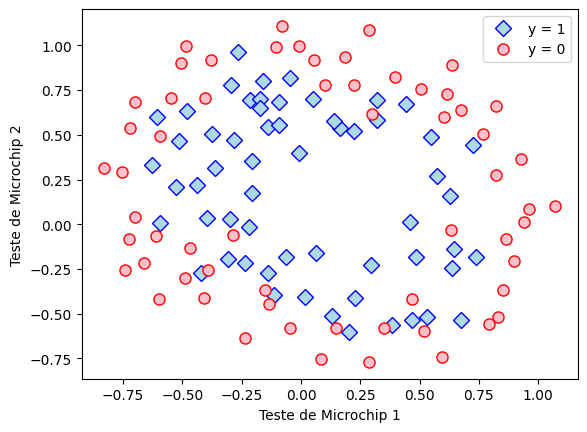

In [22]:
plotData(X, y)
# Labels e Legenda
pyplot.xlabel('Teste de Microchip 1')
pyplot.ylabel('Teste de Microchip 2')

pyplot.legend(['y = 1', 'y = 0'], loc='upper right')
pass

A figura acima nos mostra que nosso conjunto de dados não pode ser separado em amostras positivos e negativos por uma linha reta. Portanto, um aplicaçào direta da regressão logística não apresentará uma boa performance neste conjunto de dados.

### 2.2 Mapeamento de features

Uma forma de ajustar o modelo melhor ao dado é criar mais features para cada ponto de dado. Na função `mapFeature` definida no arquivo `utils.py`, mapeamos os features em termos polinomiais de $x_1$ e $x_2$ até a potência de grau seis, ou seja,

$$ \text{mapFeature}(x) = \begin{bmatrix} 1 & x_1 & x_2 & x_1^2 & x_1 x_2 & x_2^2 & x_1^3 & \dots & x_1 x_2^5 & x_2^6 \end{bmatrix}^T. $$

Como resultado desse mapeamento, nosso vetor de dois features (o resultado dos testes de qualidade) é transformado em um vetor de dimensão 8. Um classificador logístico treinado em vetores de features de dimensões superiores possuirão uma fronteira de decisão mais complexa que será não linear quando apresentado em uma visualização bidimimensional.

Se por um lado o mapeamento de features nos permite construir um classificador mais expressivo, ele também é mais suscetível ao <i>overfitting</i>. Nas próximas partes desta tarefa, você implementará uma regressão logística regularizada para ajustar o conjunto de dados, além de verificar como a regularização pode combater o problema de overfitting.

In [23]:
# Note que mapFeature já adiciona a coluna com os termos de interceptação
X = utils.mapFeature(X[:, 0], X[:, 1])

<a id="section5"></a>
### 2.3 Função custo e seu gradiente regularizados

Agora, você implementará o custo para a função custo e seu gradiente para uma regressão logística regularizada. Complete o código `costFunctionReg` abaixo para que ele retorne o custo e seu gradiente.

Lembre-se que a função custo para a regressão logística é dada por

$$ J\left(\Theta\right) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h\left(\Theta,x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h\left(\Theta,x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2 $$

Note que você não deve regularizar o viés $\theta_0$. O gradiente da função custo é um vetor cujo $j$-ésimo elemento é definido por:

$$ \frac{\partial J\left(\Theta\right)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h\left(\Theta,x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \qquad \text{for } j =0 $$

$$ \frac{\partial J\left(\Theta\right)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h\left(\Theta,x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \qquad \text{for } j \ge 1 $$
<a id="costFunctionReg"></a>

In [24]:
def costFunctionReg(theta, X, y, lambda_):
    """
    Calcula o custo e seu gradiente para uma regressão logística com 
    regularização.
    
    Parâmetros
    ----------
    theta : tipo_array
        Parâmetros da regressão logística. Um vetor na forma (n, ). n é o 
        número de features de cada amostra e o termo de viés. Se você mapeou
        os features iniciais em features polinomiais, então n é o número de
        features polinomiais.
    
    X : tipo_array
        Conjunto de dados na forma (M x n). m ;e o número de amostras, e 
        n o número de features (após o mapping).
    
    y : tipo_array
        Dado rotulado. Um vetor na forma (m, ).
    
    lambda_ : float
        Parâmetro de regularização. 
    
    Saída
    -----
    J : float
        Valor calculado da função custo
    
    grad : tipo_array
        Um vetor na forma (n, ) o qual é o gradiente da função custo
        com respeito a theta, em um dado conjunto de valores de theta.
    
    Instruções
    ----------
    Calcule o custo `J` de um theta particular.Calcule as derivadas
    parciais do custo com respeito
    a cada theta_j e atribua seus valores à quantidade grad.
    """
    # Inicializa velores úteis
    m = y.size  # número de amostras de treino

    # Você deve retornar as seguintes quantidades corretamente
    J = 0
    grad = np.zeros(theta.shape)

    J,grad = costFunction(theta, X, y)
    J += (lambda_/2/m)*np.sum(theta**2)
    grad += (lambda_/m)*theta
    
    return J, grad

Um vez que você tenha terminado com `costFunctionReg`, chamaremos a mesma na célula abaixo utilizando valores iniciais de $\Theta$ (todos nulos), além de outro caso teste (todos iguais a 1).

In [25]:
# Inicializa parâmetros de ajuste
initial_theta = np.zeros(X.shape[1])

# Atribui o parâmetrode regularização lambda_ = 1
# NÃO USE `lambda` como uma variável em python
# ela é uma palavra reservado do python.
lambda_ = 1

# Calcula e imprime o custo e seu gradiente para um regressão logística
cost, grad = costFunctionReg(initial_theta, X, y, lambda_)

print('Custo para theta inicial (zeros): {:.6f}'.format(cost))
print('Valor esperado (aprox)       : 0.693\n')

print('Gradiente para theta inicial (zeros) - apenas os 5 primeiros:')
print('\t[{:.6f}, {:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad[:5]))
print('Gradientes esperados (aprox) - apenas os 5 primeiros:')
print('\t[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]\n')


# Calcula e imprime custo e seu gradiente
# todos os theta iguais a 1 e lambda = 10
test_theta = np.ones(X.shape[1])
cost, grad = costFunctionReg(test_theta, X, y, 10)

print('------------------------------\n')
print('Custo para theta de teste    : {:.6f}'.format(cost))
print('Valor esperado (aprox): 3.16\n')

print('Gradiente para theta teste (todos 1) - apenas os 5 primeiros:')
print('\t[{:.6f}, {:.6f}, {:.6f}, {:.6f}, {:.6f}]'.format(*grad[:5]))
print('Gradientes esperados (aprox) - apenas os 5 primeiros:')
print('\t[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]')

Custo para theta inicial (zeros): 0.693147
Valor esperado (aprox)       : 0.693

Gradiente para theta inicial (zeros) - apenas os 5 primeiros:
	[0.008475, 0.018788, 0.000078, 0.050345, 0.011501]
Gradientes esperados (aprox) - apenas os 5 primeiros:
	[0.0085, 0.0188, 0.0001, 0.0503, 0.0115]

------------------------------

Custo para theta de teste    : 3.206882
Valor esperado (aprox): 3.16

Gradiente para theta teste (todos 1) - apenas os 5 primeiros:
	[0.430791, 0.161352, 0.194796, 0.226863, 0.092186]
Gradientes esperados (aprox) - apenas os 5 primeiros:
	[0.3460, 0.1614, 0.1948, 0.2269, 0.0922]
